In [6]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime

import warnings
warnings.filterwarnings('ignore', message='FixedFormatter')

respath = '../mFigures/'
date = datetime.today().strftime('%d%m%y')

In [41]:
def read_res_sheets(cohort, res_file = 'Results', date='300323', v=True):
    file = '../'+cohort+'/Results/'+cohort+'_'+res_file+'_'+date+'.xlsx'
    xl = pd.ExcelFile(file)
    for sheet in xl.sheet_names:
        if v: print(cohort+'_'+sheet, end=', ')
        df = xl.parse(sheet) # convert to dataframe
        if res_file =='Results': 
            globals()[cohort+'_'+sheet] = df.set_index('term')
        elif res_file =='splines':
            globals()[cohort+'_'+sheet] = pd.concat([df.mean(axis=1), df.min(axis=1), df.max(axis=1)], 
                                                     axis=1).rename(columns={0:'pred', 1:'lower', 2:'upper'})
        else:
            globals()[cohort+'_'+sheet] = df
    # Display names if verbose         
    if v: print('\n')

read_res_sheets('ALSPAC')
read_res_sheets('GENR')    
read_res_sheets('ALSPAC', 'predprobs', '140423')
read_res_sheets('GENR', 'predprobs')

ALSPAC_els_com, ALSPAC_els_fat, ALSPAC_els_int, ALSPAC_pre_com, ALSPAC_pre_fat, ALSPAC_pre_int, ALSPAC_pos_com, ALSPAC_pos_fat, ALSPAC_pos_int, ALSPAC_b1_els_com, ALSPAC_b1_els_fat, ALSPAC_b1_els_int, ALSPAC_b2_els_com, ALSPAC_b2_els_fat, ALSPAC_b2_els_int, ALSPAC_els_comR, ALSPAC_ad_els_com, ALSPAC_ad_els_fat, ALSPAC_ad_els_int, 

GENR_els_com, GENR_els_fat, GENR_els_int, GENR_pre_com, GENR_pre_fat, GENR_pre_int, GENR_pos_com, GENR_pos_fat, GENR_pos_int, GENR_b1_els_com, GENR_b1_els_fat, GENR_b1_els_int, GENR_b2_els_com, GENR_b2_els_fat, GENR_b2_els_int, GENR_els_comR, GENR_ad_els_com, GENR_ad_els_fat, GENR_ad_els_int, 

ALSPAC_els_exerc_pps, ALSPAC_els_mdiet_pps, ALSPAC_els_sleep_pps, 

GENR_els_exerc_pps, GENR_els_mdiet_pps, GENR_els_sleep_pps, GENR_pos_exerc_pps, GENR_pos_mdiet_pps, GENR_pos_sleep_pps, GENR_pre_exerc_pps, GENR_pre_mdiet_pps, GENR_pre_sleep_pps, 



In [178]:
ALSPAC_els_int.loc[ALSPAC_els_int.model=='exerc_z'].loc['(Intercept)','estimate']

-2.43070685262338

In [3]:
# General plotting settings
# Set up size of text in figures
f1 = 20
f2 = 18
f3 = 14

lbls=['High internalizing','High adiposity', 'Comorbidity']
clrs=['royalblue','orange','indianred']

mods = {'exerc':['Exercise','Exercise\ frequency'],
        'sleep':['Sleep','Sleep\ duration'],
        'mdiet':['Diet','Mediterranean\ diet\ score']}

# create colormap
def make_map(colors, n=5):
    return matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=n)


## Figure 1

In [4]:
ALSP = pd.read_csv('../ALSPAC/Data/byimp/imp0.csv')
GENR = pd.read_csv('../GENR/Data/byimp/imp0.csv')

In [59]:
ALSP.ELS_z.describe()

count    4797.000000
mean       -0.095847
std         0.898909
min        -1.736463
25%        -0.747976
50%        -0.284086
75%         0.384769
max         4.753152
Name: ELS_z, dtype: float64

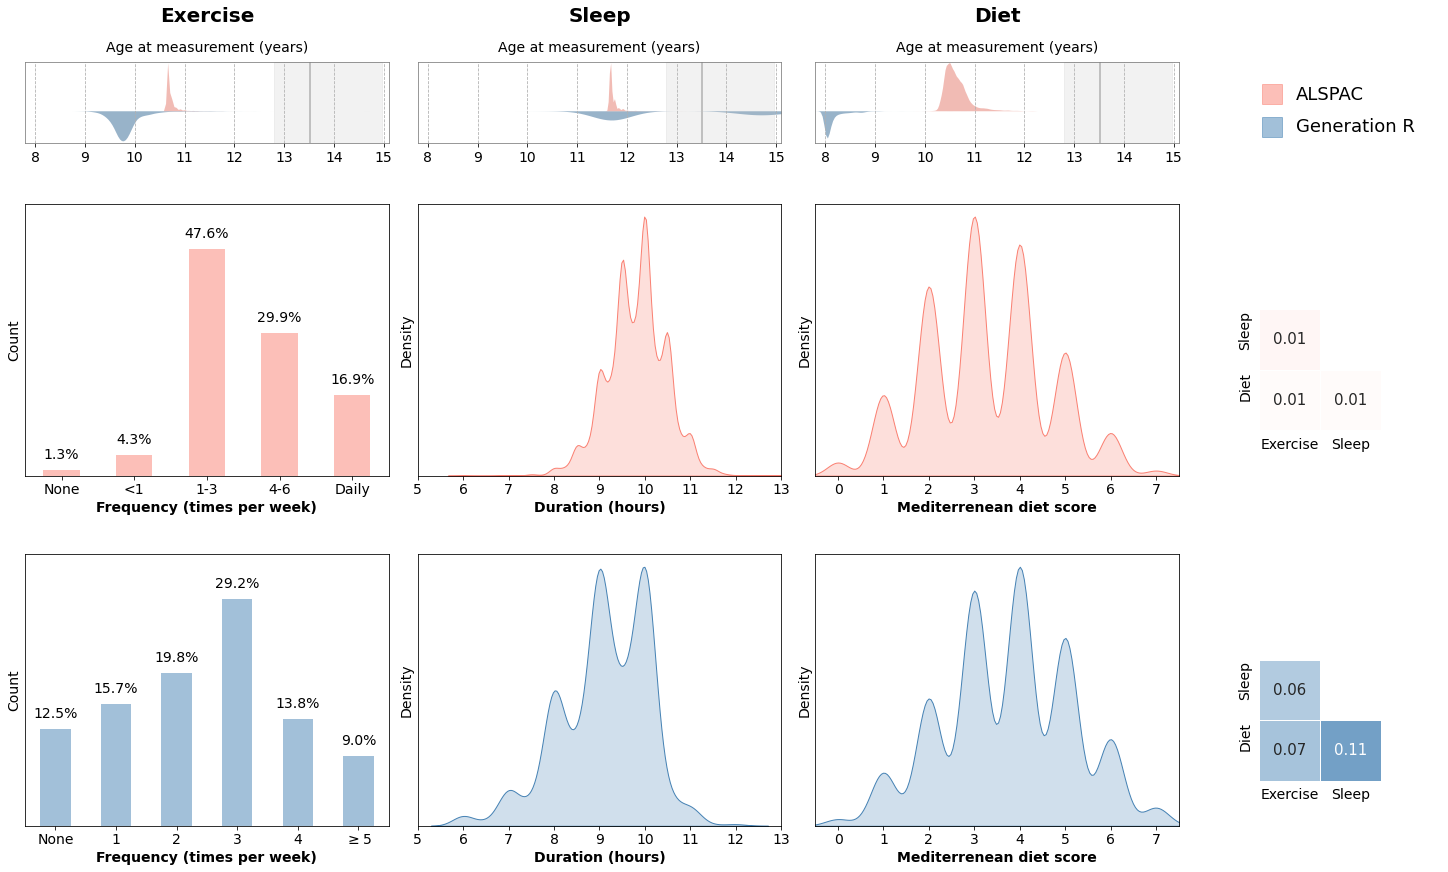

In [8]:
# Lifestyle descriptives figure
def ages_plot(ax, var):
    # Get data
    data = pd.DataFrame({'g': GENR[var+'_age'], 'a': ALSP[var+'_age'], }).melt()
    data['dummy'] = 0
    # Plot it 
    p = sns.violinplot(ax=ax, data=data, x='value', y='dummy', hue='variable', split=True, 
                       palette = ['steelblue','salmon'], 
                       scale='count', width=1, orient='h', inner=None, linewidth=0)
    # Clean axes and set limits
    p.set(ylabel=None, yticks=[], ylim=(-0.34,0.51), xlim=(7.8,15.1))
    p.legend([],[], frameon=False)
    # Adjust color
    plt.setp(p.collections, alpha=.6)
    # Add vertical grid
    ax.grid(which='major', axis='x', linestyle='--')
    # Add reference outcome measured
    age_avg = (ALSP.age_child.mean()+GENR.age_child.mean())/2
    age_min = max(ALSP.age_child.min(), GENR.age_child.min())
    age_max = min(ALSP.age_child.max(), GENR.age_child.max())
    ax.axvline(age_avg, color = 'silver', ls = '-', lw = 2)
    ax.axvspan(age_min,age_max,color = 'silver', alpha=0.2)
    
    for spine in ax.spines.values(): spine.set_edgecolor('grey')
    # Add x- axis ticks and label
    ax.set_xlabel('Age at measurement (years)', fontsize=f3, labelpad=10)
    ax.xaxis.set_label_position('top') 
    ax.set_xticklabels(list(range(7,16)), fontsize=f3);
    # Add title
    ax.set_title(mods[var][0], fontsize=f1, fontweight='bold', pad=40)
    
def hist_exerc(ax, cohort):
    lvls = ['none','<1 week','1-3 week','4-6 week','daily'] if cohort=='ALSP' else ['none','1 week','2 week','3 week','4 week','>=5 week']
    lbls = ['None','<1','1-3','4-6','Daily'] if cohort=='ALSP' else ['None','1','2','3','4',r'$\geq$5']
    colr = 'salmon' if cohort=='ALSP' else 'steelblue'
    df = globals()[cohort]['exerc_fac'].value_counts().loc[lvls]
    p = df.plot.bar(ax=ax, color=colr, alpha=0.5)
    
    for i, val in enumerate(df):
        perc = round(val/df.sum()*100,1)
        p.text(i, val+(df.max()/20), str(perc)+'%', ha='center', fontsize=f3)
    
    p.set_xticklabels(lbls, rotation=0, fontsize=f3)
    p.set_yticks([])
    p.set_ylim(0,df.max()+(df.max()/5))
    p.set_xlabel('Frequency (times per week)', fontsize=f3, fontweight='bold')
    p.set_ylabel('Count', fontsize=f3)
    p.set_title('\n', fontsize=f3)

def dense_plot(ax, cohort, var):
    colr = 'salmon' if cohort=='ALSP' else 'steelblue'
    if var=='SRsleep': colr = 'lightsteelblue'
    title, xlab, xlim = ['Diet','Mediterrenean diet score',(-0.5,7.5)] if var =='mdiet' else [
                         'Sleep','Duration (hours)',(5,13)]
    df = globals()[cohort]
    sns.kdeplot(df[var], ax=ax, color=colr, shade=True, linewidth=1)
    ax.set_xlabel(xlab, fontsize=f3, fontweight='bold')
    ax.set_ylabel('Density', fontsize=f3)
    ax.set_yticks([])
    xlbs = range(-1,8) if var=='mdiet' else range(xlim[0],xlim[1]+1)
    ax.set_xticklabels(list(xlbs), fontsize=f3)
    ax.set_xlim(xlim)
    ax.set_title('\n', fontsize=f3)
    
def corrs_plot(ax, cohort):
    cor = globals()[cohort][['exerc','sleep','mdiet']].corr()
    maskmat = np.triu(cor)
    
    cmap = make_map(['w','salmon'], 30) if cohort=='ALSP' else make_map(['w','steelblue'],30)
    
    cm = sns.heatmap(cor, ax=ax, annot=True, fmt='.2f', square=True, annot_kws={"size":15},
            cmap=cmap, vmin=0, vmax=0.15, linewidths=1,
            xticklabels = ['Exercise\n\n\n','Sleep\n\n\n',''], yticklabels = ['','\n\n\nSleep','\n\n\nDiet'],
            cbar=False, mask=maskmat)
    
    ax.tick_params(axis='both', which='major', labelsize = f3, left=False, bottom=False)

    
# ----------------------------------------------------------------
f = plt.figure(constrained_layout=True, figsize=(20, 12))

axs = f.subplot_mosaic('ABCx;DEFG;HIJK', height_ratios=[0.6,2,2], width_ratios=[2,2,2,1])

# axs['x'].set_visible(False)
axs['x'].set(xlim=(0,1), ylim=(0,1))
axs['x'].axis('off')
axs['x'].plot(0.07, 0.6, 's', ms=20, alpha=.5, color='salmon')
axs['x'].plot(0.07, 0.2, 's', ms=20, alpha=.5, color='steelblue')
axs['x'].text(0.2, 0.6, 'ALSPAC', fontsize=f2, va='center')
axs['x'].text(0.2, 0.2, 'Generation R', fontsize=f2, va='center')

ages_plot(axs['A'], 'exerc')
ages_plot(axs['B'], 'sleep')
ages_plot(axs['C'], 'mdiet')

hist_exerc(axs['D'],'ALSP')
dense_plot(axs['E'],'ALSP','sleep')
dense_plot(axs['F'],'ALSP','mdiet')
corrs_plot(axs['G'],'ALSP')

hist_exerc(axs['H'],'GENR')
dense_plot(axs['I'],'GENR','sleep') #; dense_plot(axs['I'],'GENR','SRsleep')
dense_plot(axs['J'],'GENR','mdiet')
corrs_plot(axs['K'],'GENR')

f.savefig(respath+'1.Mod-descr.pdf', dpi=400)

## Figure 2

In [224]:

# bold significant
def bold_sign(m, ax):
    sign = m.reset_index().index[m['p.value']<0.050].to_list()
    for pos in sign:
        ax.get_yticklabels()[pos].set_weight("bold") 

def plot_maineff(ax, cohort, els='ELS_z', out_name = 'Comorbidity'):
    
    exp = els[:3].lower()
    out = 'fat' if out_name=='Adiposity' else out_name[:3].lower()
    
    d = globals()[cohort+'_'+exp+'_'+out]
    if out =='com': d = d.loc[d['y.level']=='H:comorb']
    
    mod_est = d.loc[d.index.str.contains('^exerc|^sleep|^mdiet', na=False)]
    els_est = d.loc[els][:3]
    
    mod_labels = ['Exercise','Sleep','Diet']
    
    c='k'; fmt='s'; ms=10; elw=3; cap=10
    
    if out =='com': # Plot OR comorbidity
        ax.errorbar(mod_est['OR'], mod_labels, xerr = [mod_est['OR']-mod_est['lci'], mod_est['uci']-mod_est['OR']], 
                    color=c, fmt=fmt, ms=ms, elinewidth=elw, capsize=cap, label='Lifestyle\nfactors')
        ax.errorbar(els_est['OR'], mod_labels, xerr = [els_est['OR']-els_est['lci'], els_est['uci']-els_est['OR']], 
                    color=c, fmt=fmt, ms=ms, elinewidth=elw, capsize=cap, label='ELS', alpha=0.3)
        ref = 1; xlim = (0.5,4); xlab = 'OR estimate (vs. healthy)'
    else: # Plot betas
        ax.errorbar(mod_est['estimate'], mod_labels, xerr = list(mod_est['std.error']*1.96), 
                    color=c, fmt=fmt, ms=ms, elinewidth=elw, capsize=cap, label='Lifestyle\nfactors')
        ax.errorbar(els_est['estimate'], mod_labels, xerr = list(els_est['std.error']*1.96),
                    color=c, fmt=fmt, ms=ms, elinewidth=elw, capsize=cap, label='ELS', alpha=0.3)
        ref = 0; xlim = (-0.13,0.5); xlab = r'$\beta $ estimate'
    
    # Add vertical dotted line indicating beta = 0 or OR = 1.
    ax.axvline(x = ref, color = 'grey', ls = '--', lw = 1)
    # Add axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(-0.6, 2.6)
    # Invert y-axis
    ax.invert_yaxis()
    # Adjust axis parameter
    ax.tick_params(axis='both', which='major', labelsize = f3)
    # Add x-label 
    ax.set_xlabel(xlab, fontsize = f2, labelpad = 7)
    # Add a title 
    ax.set_title('\n'+out_name+' - Main effects', fontweight = 'bold', fontsize = f1, pad = 10) #'\n'+out_name
    # Add legend
    ax.legend(fontsize=f3, loc='upper right', ncol=1, framealpha=0) # bbox_to_anchor=(1, 1.1),
    # Bold significant terms
    bold_sign(mod_est, ax)  

def plot_interac(ax, cohort, mod, els='ELS_z', out_name='Comorbidity'):
    
    exp = els[:3].lower()
    d = globals()[cohort+'_'+exp+'_'+mod+'_pps']
    
    lvls = d[mod].unique()
    if mod=='sleep': lvls = lvls[:-1]
    if (cohort=='ALSPAC' and mod=='exerc'): lvls = lvls[:-1]
    
    cmap = make_map(['#99000d','violet','royalblue','forestgreen'], n=len(lvls)) # blue #0c2c84
    
    exerc_frq = ['None','<1 time p.w.','1-3 times p.w.','4-6 times p.w.','Daily'] if cohort=='ALSPAC' else [
                 'None','1 time p.w.','2 times p.w.','3 times p.w.','4 times p.w.',r'$\geq$5 times p.w.']
    
    mods = {'exerc':['Exercise','Exercise\ frequency', exerc_frq],
            'sleep':['Sleep','Sleep\ duration', [str(h)+' hours' for h in lvls]],
            'mdiet':['Diet','Mediterranean\ diet\ score', lvls]}

    for i, v in enumerate(lvls):
        ss = d.loc[d[mod]==v].set_index(els)
        
        ax.plot(ss['mean'], '--', dashes=(6, 1), label=mods[mod][2][i], color=cmap(i))
        ax.fill_between(ss.index, ss.lower, ss.upper, color=cmap(i), alpha=0.05)
    
    # Add axis limits
    ax.set(xlim = (-1.75, 4.75), ylim = (0.0, 0.6))
    # Adjust axis parameter
    ax.tick_params(axis='both', which='major', labelsize = f3)
    # Add x and y-label 
    ax.set_xlabel('ELS (z-score)', fontsize = f2, labelpad = 7)
    ax.set_ylabel('prob( comorbidity )', fontsize = f2, labelpad = 7)
    # Add a title 
    ax.set_title('\nELS * '+mods[mod][0], fontweight = 'bold', fontsize = f1, pad = 10) #'\n'+out_name
    # Add legend
    ax.legend(loc='upper left', ncol=1, fontsize=f3, framealpha=0, # bbox_to_anchor=(1, 1.1),
              title='$\\bf{'+mods[mod][1]+'}$', title_fontsize=f3, alignment='left')
        

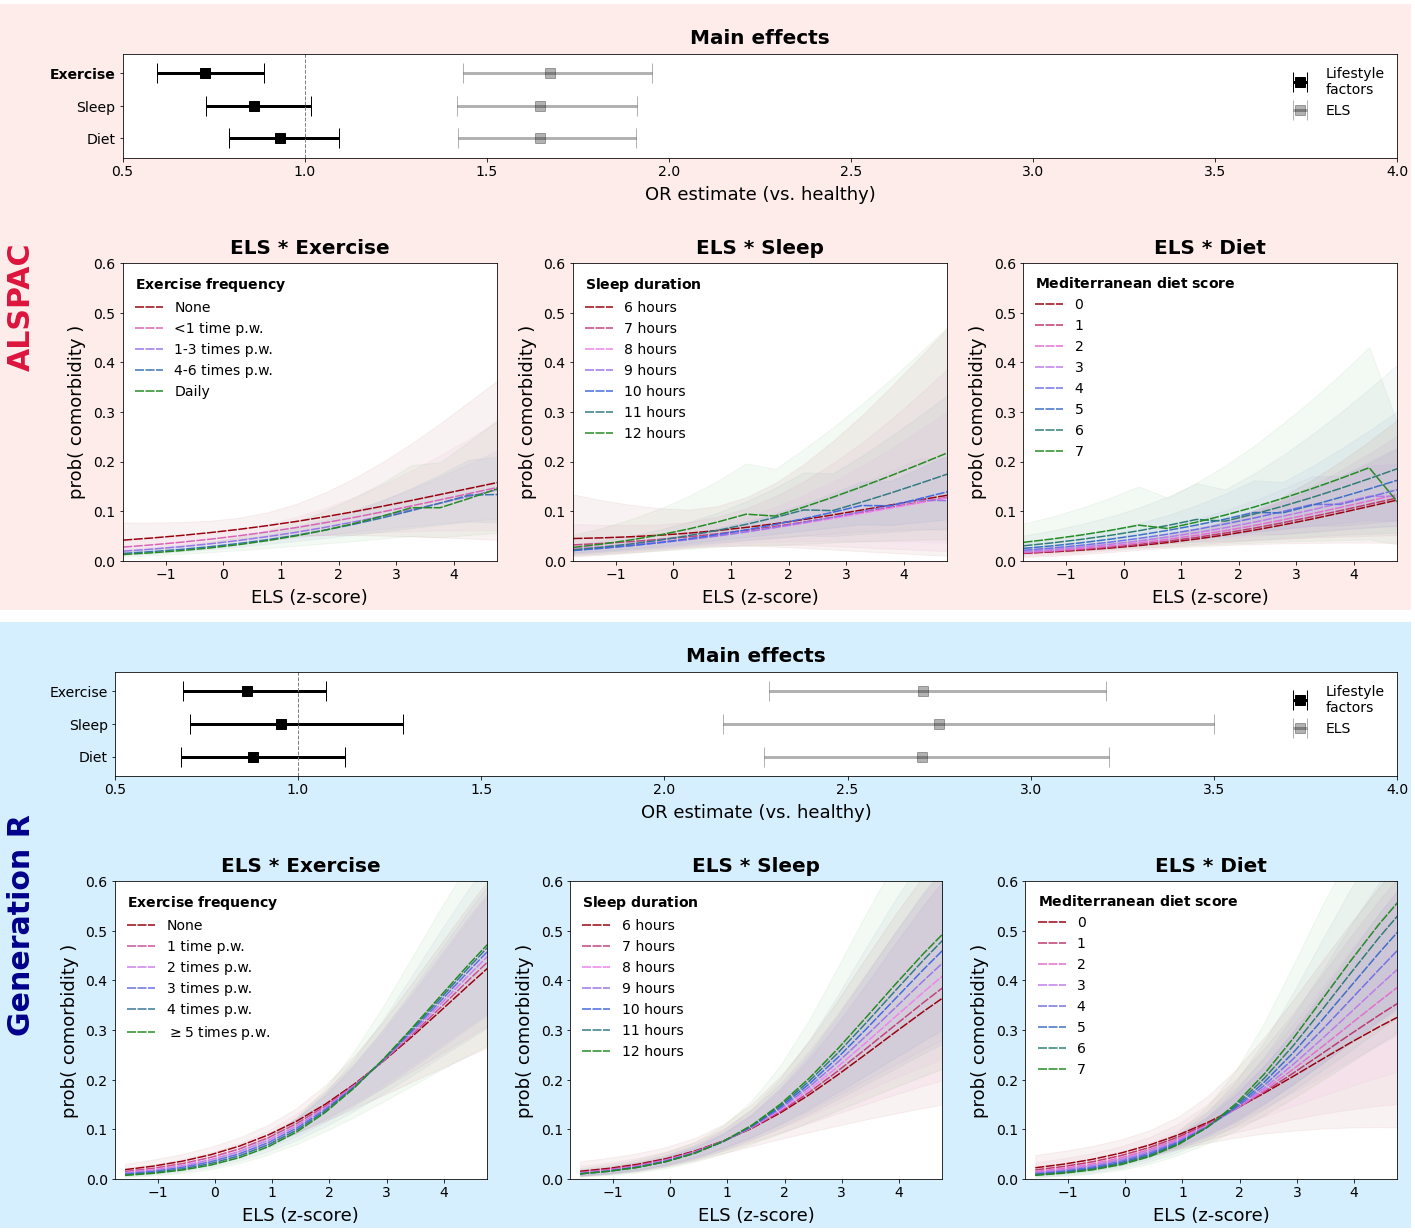

In [62]:
def fig_setup(subf, cohort, els='ELS_z'):
    background = '#FDECEA' if cohort == 'ALSPAC' else '#D6EFFE' # pink and lightblue
    subf.set_facecolor(background)
    
    axs = subf.subplot_mosaic('.AAA;.BCD', height_ratios=[0.7,2], width_ratios=[0.4,2,2,2]) #"xAAAAy;BBCCDD" sharey=True
    
    plot_maineff(axs['A'], cohort, els=els)
    plot_interac(axs['B'], cohort, 'exerc', els=els)
    plot_interac(axs['C'], cohort, 'sleep', els=els)
    plot_interac(axs['D'], cohort, 'mdiet', els=els)
    
    title = 'Generation R' if cohort == 'GENR' else 'ALSPAC'
    clr_title = 'darkblue' if cohort == 'GENR' else 'crimson'
    subf.text(0.035, 0.5, title, fontweight='bold', fontsize=f1+10, color=clr_title, rotation=90, 
              ha='center', va='center')


f = plt.figure(constrained_layout=True, figsize=(20, 17))

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)

fig_setup(subf1, 'ALSPAC')
fig_setup(subf2, 'GENR')

f.savefig(respath+'2.Main-results.pdf', dpi=400)

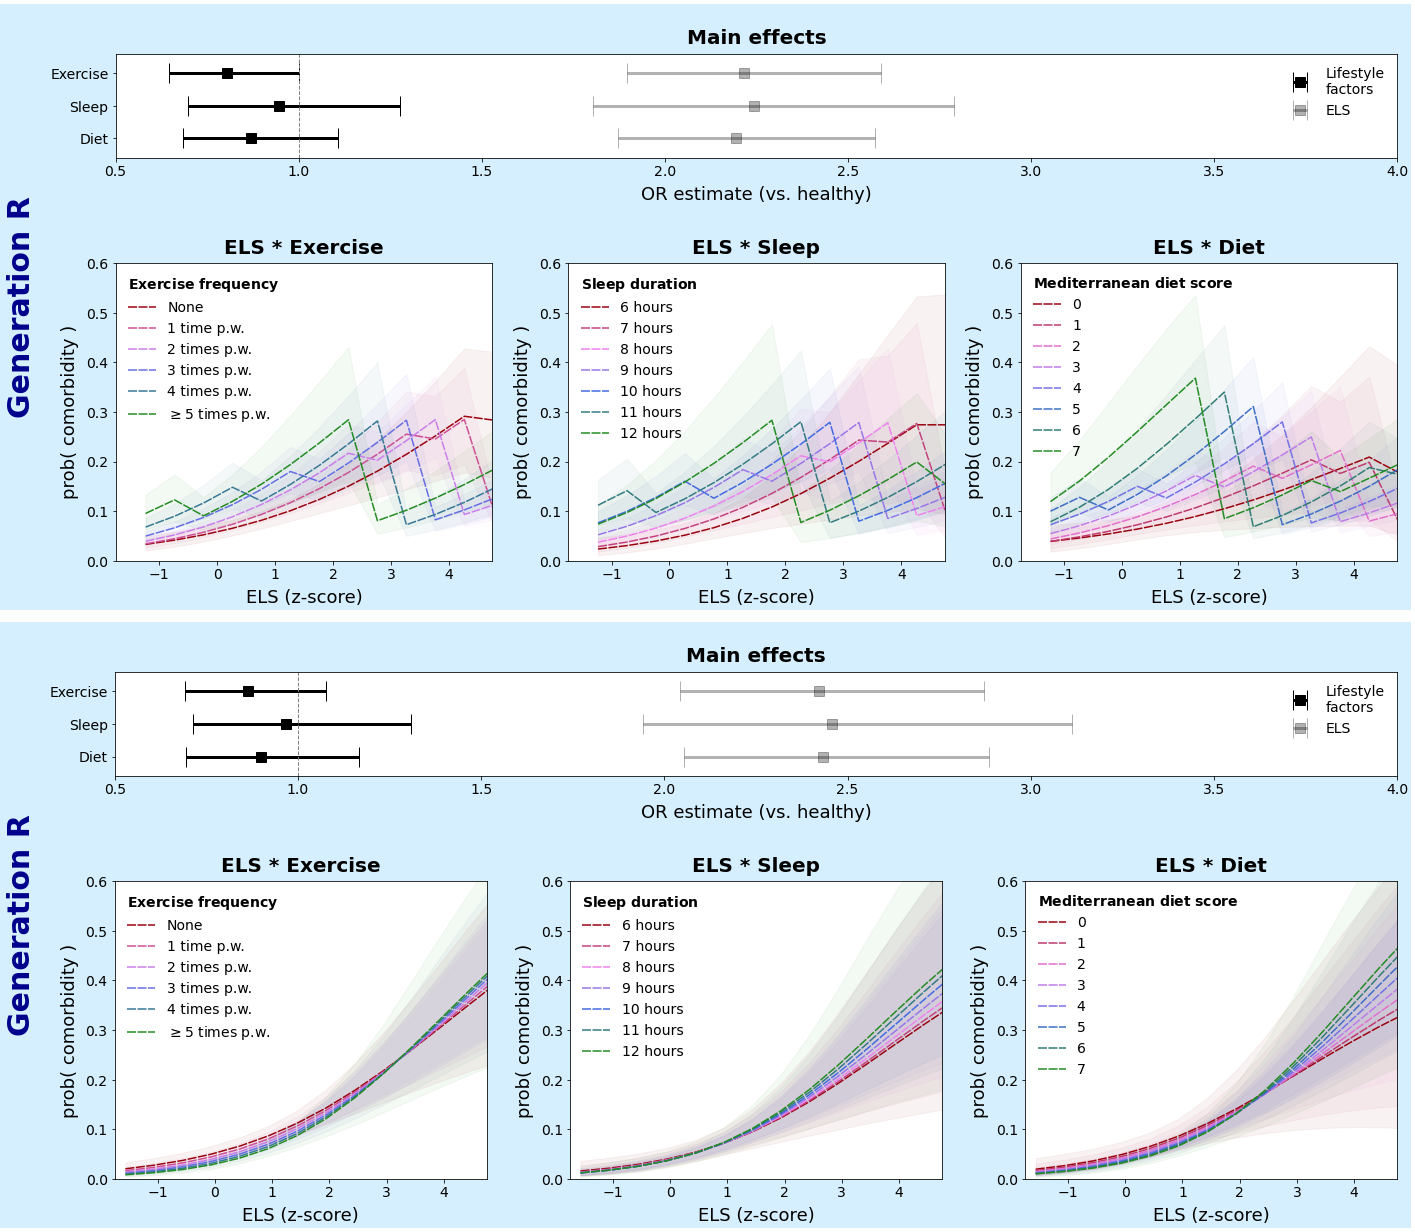

In [63]:
f = plt.figure(constrained_layout=True, figsize=(20, 17))

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)

# fig_setup(subf1, 'ALSPAC')
fig_setup(subf1, 'GENR', els='prenatal_stress_z')
fig_setup(subf2, 'GENR', els='postnatal_stress_z')

## Linear models 

In [88]:
read_res_sheets('ALSPAC', 'simpslopes', '170423')
read_res_sheets('GENR', 'simpslopes', '170423')

ALSPAC_adi_exerc_ssl, ALSPAC_adi_mdiet_ssl, ALSPAC_adi_sleep_ssl, ALSPAC_int_exerc_ssl, ALSPAC_int_mdiet_ssl, ALSPAC_int_sleep_ssl, 

GENR_adi_exerc_ssl, GENR_adi_mdiet_ssl, GENR_adi_sleep_ssl, GENR_int_exerc_ssl, GENR_int_mdiet_ssl, GENR_int_sleep_ssl, 



In [241]:
mod='exerc'
float(ALSPAC_els_fat.loc[ALSPAC_els_fat.index.str.contains(':'+mod,na=False), 'p.value'])

0.7039

In [264]:
def plot_lninter(ax, cohort, mod, els='ELS_z', out_name=''):
    
    exp = els[:3].lower()
    out = out_name[:3].lower()
    d = globals()[cohort+'_'+out+'_'+mod+'_ssl'] # .set_index(mod)
    
    cmap = make_map(['#99000d','violet','royalblue','forestgreen'], n=d.shape[0]) # blue #0c2c84
    
    exerc_frq = ['None','<1 time p.w.','1-3 times p.w.','4-6 times p.w.','Daily'] if cohort=='ALSPAC' else [
                 'None','1 time p.w.','2 times p.w.','3 times p.w.','4 times p.w.',r'$\geq$5 times p.w.']
    
    mods = {'exerc':['Exercise','Exercise\ frequency', exerc_frq],
            'sleep':['Sleep','Sleep\ duration', [str(h)+' hours' for h in list(range(6,14))]],
            'mdiet':['Diet','Mediterranean\ diet\ score', list(range(0,8))]}
    
    x = np.linspace(-1.75, 4.75)
    
    # Intercept 
    if out =='adi': out='fat'
    res = globals()[cohort+'_'+exp+'_'+out]
    icpt = res.loc[res.model==mod+'_z'].loc['(Intercept)','estimate']
    p = float(res.loc[res.index.str.contains(':'+mod,na=False), 'p.value'])
    
    for i, e in enumerate(d['mean']):
        ax.plot(x, e*x, '--', dashes=(6, 1), label = mods[mod][2][i], color=cmap(i))
        ax.fill_between(x, d.lower[i]*x, d.upper[i]*x, color=cmap(i), alpha=0.05)

    # Add axis limits
    ax.set( xlim = (-1.75, 4.75), ylim = (-0.5, 2)) # 
    # Adjust axis parameter
    ax.tick_params(axis='both', which='major', labelsize = f3)
    # Add x and y-label 
    ax.set_xlabel('ELS (z-score)', fontsize = f2, labelpad = 7)
    if not mod=='exerc': 
        ax.set_ylabel('') 
    else: 
        ax.set_ylabel(out_name+' (z-score)', fontsize = f2, fontweight='bold', labelpad = 7)
    # Add a title 
    ax.set_title('\nELS * '+mods[mod][0], fontweight = 'bold', fontsize = f1, pad = 10) #'\n'+out_name
    # Add legend
    ax.legend(loc='upper left', ncol=1, fontsize=f3, framealpha=0, # bbox_to_anchor=(1, 1.1),
              title='$\\bf{'+mods[mod][1]+'}$', title_fontsize=f3, alignment='left')
    # Add p-value
    ax.text(3.3,-0.4,'P*= %.3f'%p, fontsize=f3)


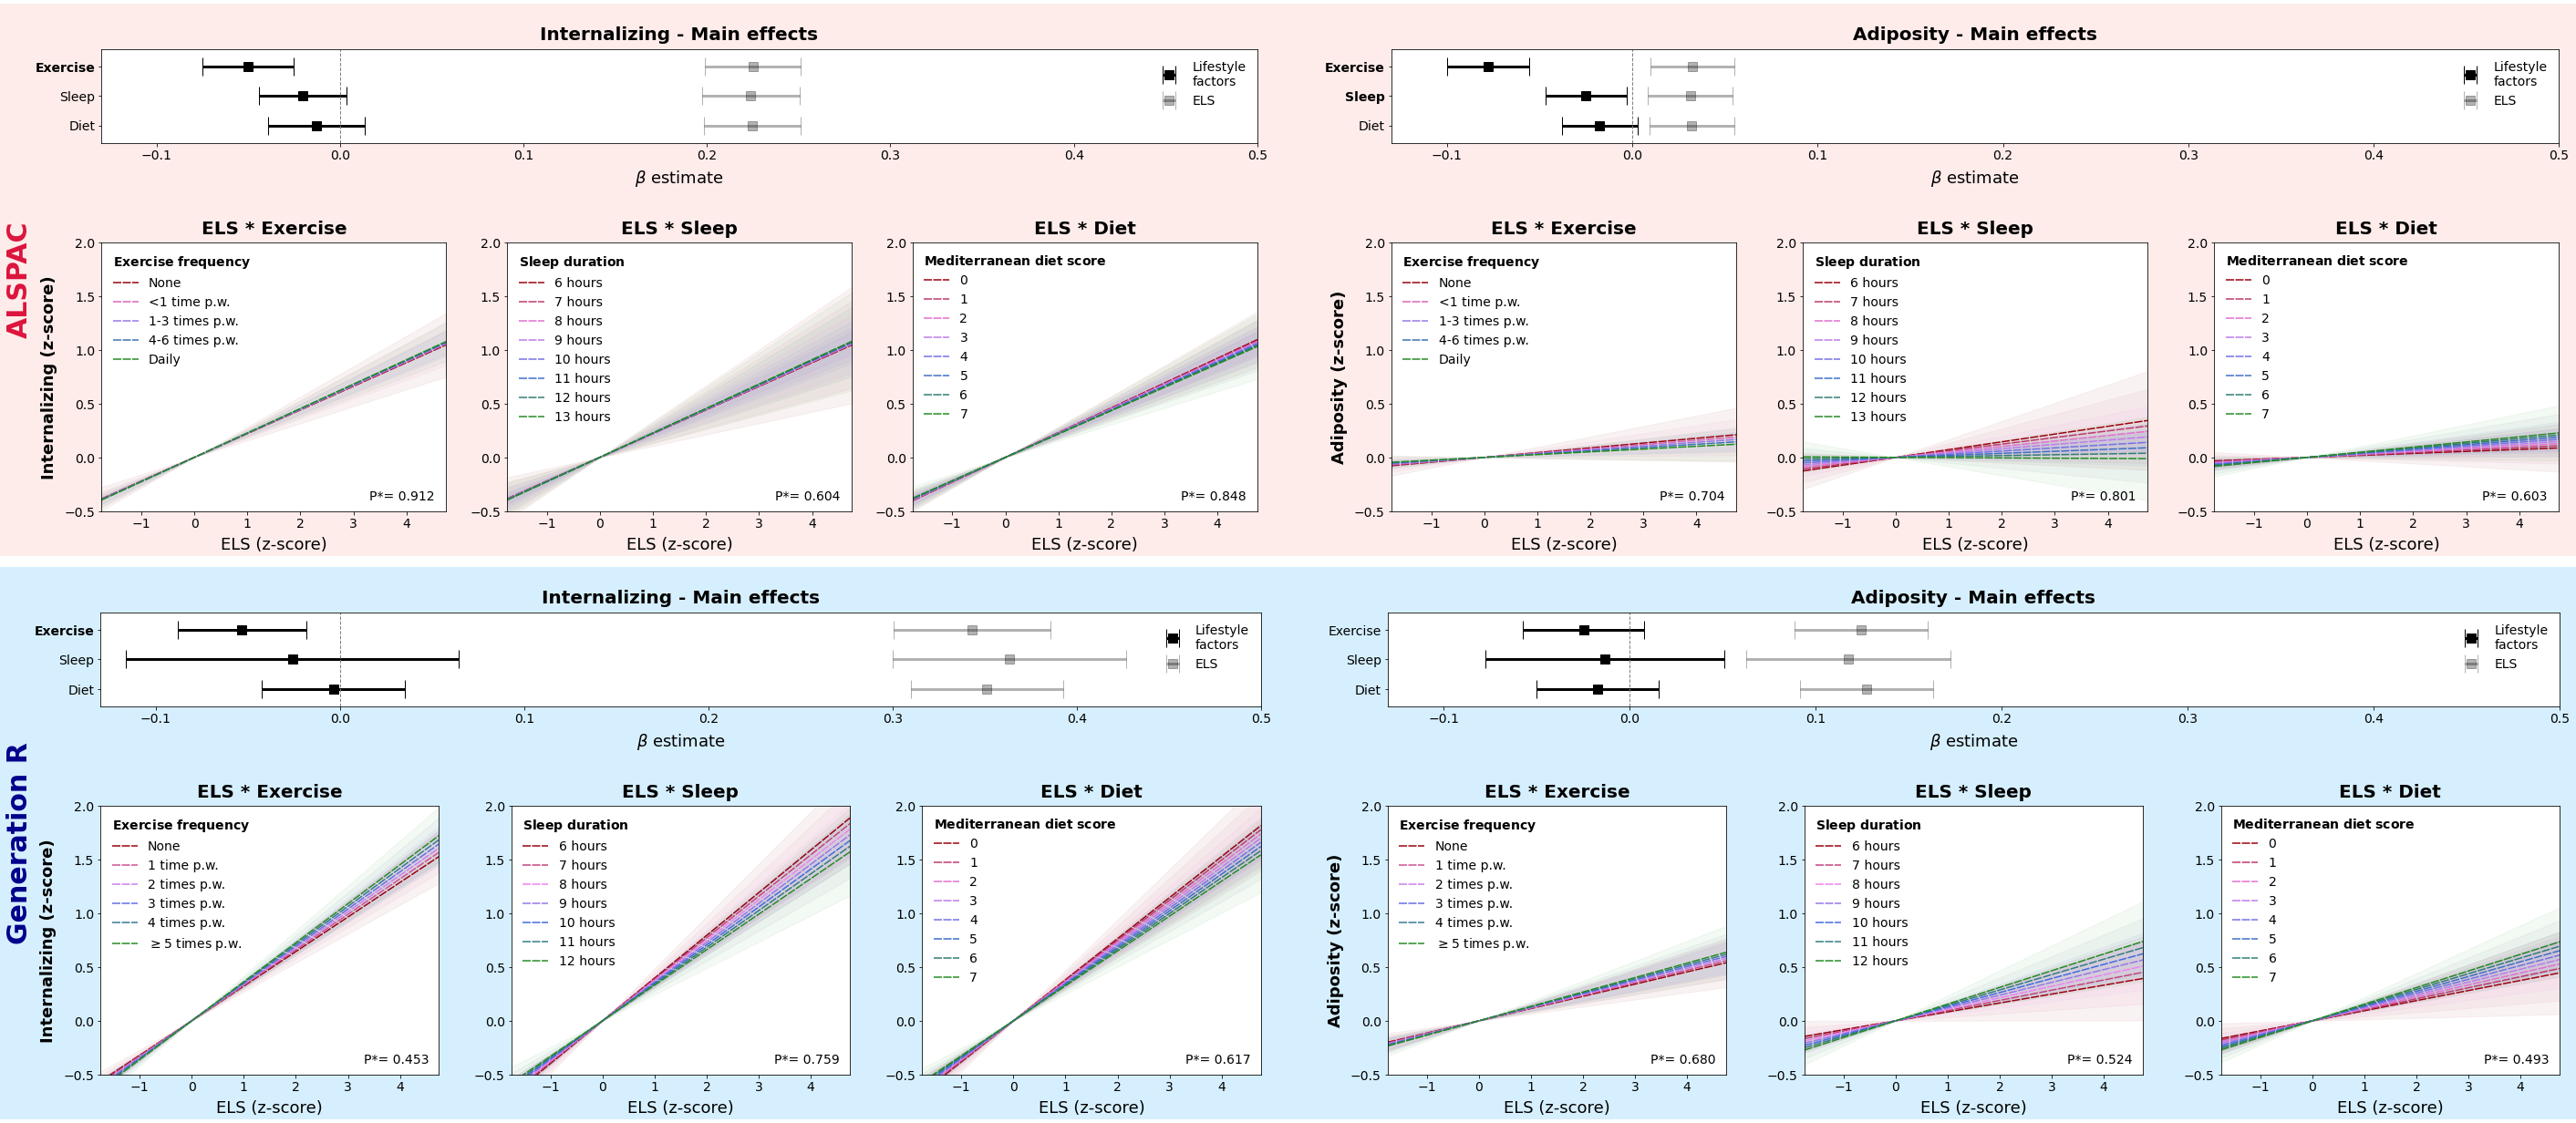

In [267]:
def fig_setup(subf, cohort, els='ELS_z'):
    background = '#FDECEA' if cohort == 'ALSPAC' else '#D6EFFE' # pink and lightblue
    subf.set_facecolor(background)
    
    axs = subf.subplot_mosaic('.AAA.BBB.;.CDE.FGH.', height_ratios=[0.7,2], 
                              width_ratios=[0.3]+[2]*3+[0.3]+[2]*3+[0.2]) #"xAAAAy;BBCCDD" sharey=True
    
    plot_maineff(axs['A'], cohort, els=els, out_name='Internalizing')
    plot_maineff(axs['B'], cohort, els=els, out_name='Adiposity')
    plot_lninter(axs['C'], cohort, 'exerc', els=els, out_name='Internalizing')
    plot_lninter(axs['D'], cohort, 'sleep', els=els, out_name='Internalizing')
    plot_lninter(axs['E'], cohort, 'mdiet', els=els, out_name='Internalizing')
    plot_lninter(axs['F'], cohort, 'exerc', els=els, out_name='Adiposity')
    plot_lninter(axs['G'], cohort, 'sleep', els=els, out_name='Adiposity')
    plot_lninter(axs['H'], cohort, 'mdiet', els=els, out_name='Adiposity')
    
    title = 'Generation R' if cohort == 'GENR' else 'ALSPAC'
    clr_title = 'darkblue' if cohort == 'GENR' else 'crimson'
    subf.text(0.015, 0.5, title, fontweight='bold', fontsize=f1+10, color=clr_title, rotation=90, 
              ha='center', va='center')


f = plt.figure(constrained_layout=True, figsize=(40, 17))

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)

fig_setup(subf1, 'ALSPAC')
fig_setup(subf2, 'GENR')

f.savefig(respath+'3.Lin-results.pdf', dpi=400)

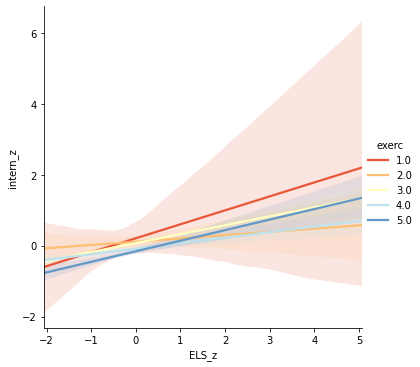

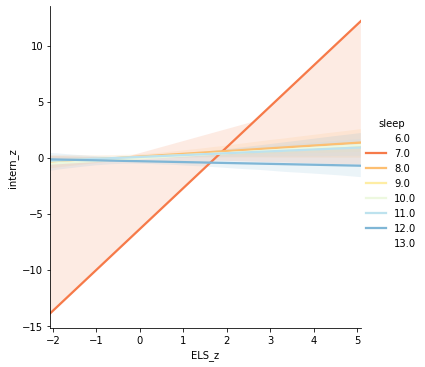

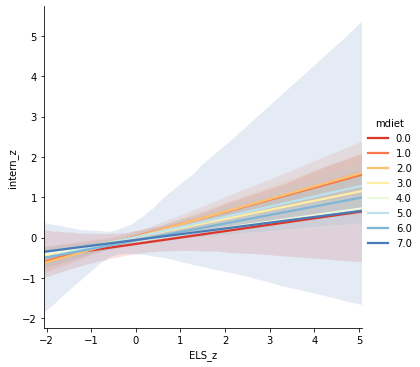

In [214]:
def check_slope(cohort, mod, out='intern_z'):
    cohort['sleep'] = round(cohort['sleep'])
    sns.lmplot(x="ELS_z", 
           y="intern_z", 
           hue=mod , scatter=False, palette='RdYlBu',
           data=cohort, truncate=False)

for m in ['exerc','sleep','mdiet']:
    check_slope(ALSP, m, out='intern_z')

## NON LINEARITY 

In [29]:
# read_res_sheets('ALSPAC','splines') # Gotta fix the file
read_res_sheets('GENR','splines')

GENR_intern_exerc, GENR_intern_sleep, GENR_intern_mdiet, GENR_adipos_exerc, GENR_adipos_sleep, GENR_adipos_mdiet, 



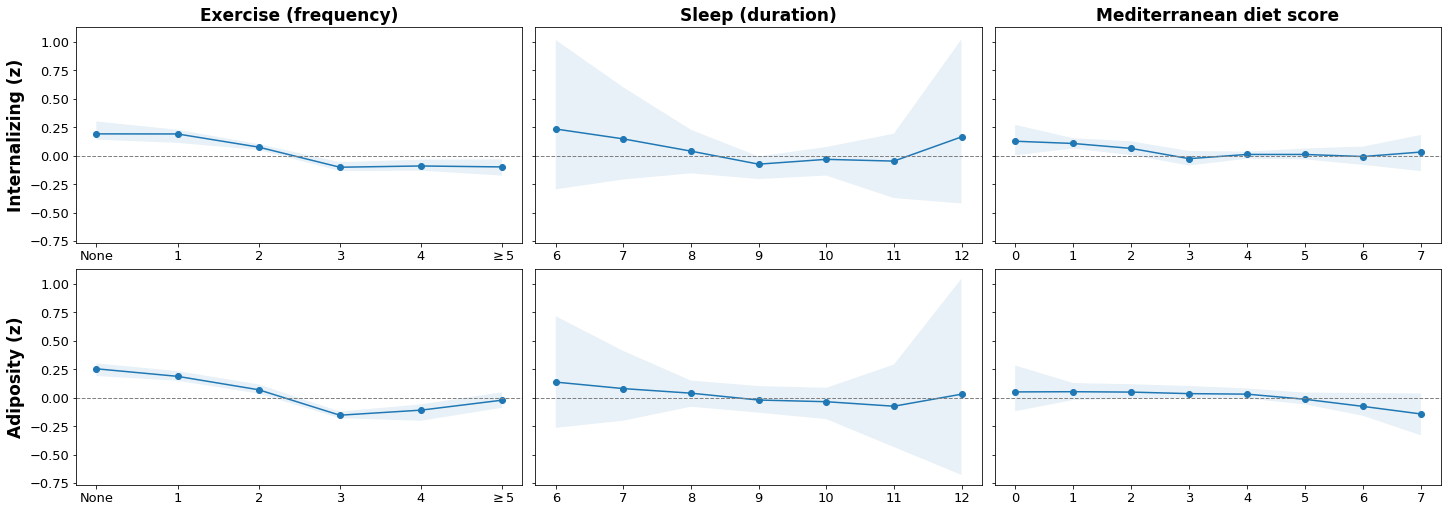

In [30]:
f, axs = plt.subplots(2,3,constrained_layout=True, figsize=(20, 7), sharey=True)

ms = {'exerc':'Exercise (frequency)','sleep':'Sleep (duration)','mdiet':'Mediterranean diet score'}

def plot_spline(ax, outc, mod, cohort='GENR'):
    d = globals()[cohort+'_'+outc+'_'+mod]
    ax.plot(d.pred, '-o')
    ax.fill_between(d.index, d.lower, d.upper, alpha=0.1)
    ax.axhline(y = 0, color = 'grey', ls = '--', lw = 1)
    ylab = 'Internalizing (z)' if outc =='intern' else 'Adiposity (z)'
    if mod =='exerc': ax.set_ylabel(ylab, fontsize=17, fontweight='bold')
    if outc =='intern': ax.set_title(ms[mod], fontsize=17, fontweight='bold')
        
    if mod == 'exerc': 
        lbls = ['None','<1','1-3','4-6','Daily'] if cohort=='ALSPAC' else ['-','None','1','2','3','4',r'$\geq$5']
        ax.set_xticklabels(lbls)
    if mod == 'sleep': ax.set_xticklabels(list(range(5, 13)))
        
    ax.tick_params(axis='both', which='major', labelsize = 13)

plot_spline(axs[0,0], 'intern', 'exerc', 'GENR')
plot_spline(axs[0,1], 'intern', 'sleep', 'GENR')
plot_spline(axs[0,2], 'intern', 'mdiet', 'GENR')

plot_spline(axs[1,0], 'adipos', 'exerc', 'GENR')
plot_spline(axs[1,1], 'adipos', 'sleep', 'GENR')
plot_spline(axs[1,2], 'adipos', 'mdiet', 'GENR')


### Stratified plot of interaction

In [ ]:
def plot_inter(axs, cohort, els='ELS_z', comp='H:multim'):
    
    m1,r1,_ = subset_bin('intr_bin', cohort, els)
    m2,r2,_ = subset_bin('fatm_bin', cohort, els)
    m3,r3,_ = subset_bin('bin', cohort, els)

    ax1,ax2,ax3 = axs
    
    mod_labels = ['Exercise','Sleep','Diet']
    
    # Plot betas inernalizing
    ax1.errorbar(r1['estimate'], mod_labels, xerr = list(r1['std.error']*1.96), color='green',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    ax1.errorbar(m1['estimate'], mod_labels, xerr = list(m1['std.error']*1.96), color='darkviolet',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    # Plot betas adiposity
    ax2.errorbar(r2['estimate'], mod_labels, xerr = list(r2['std.error']*1.96), color='green',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    ax2.errorbar(m2['estimate'], mod_labels, xerr = list(m2['std.error']*1.96), color='darkviolet',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    # Plot OR comorbidity
    ax3.errorbar(r3['OR'], mod_labels, xerr = [r3['OR']-r3['lci'], r3['uci']-r3['OR']], color='green',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    ax3.errorbar(m3['OR'], mod_labels, xerr = [m3['OR']-m3['lci'], m3['uci']-m3['OR']], color='darkviolet',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    
    #add a vertical dotted line indicating beta = 0 or OR = 1.
    ax1.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
    ax2.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
    ax3.axvline(x = 1, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    
    # Add x axis limit 
    ax1.set_xlim(-0.07,0.55); ax2.set_xlim(-0.07,0.55); ax3.set_xlim(0.78,4.3)
    
    # Add legend
    ax3.legend(['','Adhering','Not\nadhering'], fontsize=f3, 
               bbox_to_anchor=(1, 1.1), loc='upper left',ncol=1, framealpha=0)
    
    titles = ['Internalizing', 'Adiposity', 'Comorbidity']
    xlables = [r'ELS $\beta $ estimate',r'ELS $\beta $ estimate','ELS OR estimate (vs. healthy)']
    
    for n,ax in enumerate(axs):
        ax.set_ylim(-0.6,2.6)
        # add x-label 
        ax.set_xlabel(xlables[n], fontsize = f2, labelpad=7)
        # add a title 
        ax.set_title('\n'+titles[n], fontweight = 'bold', fontsize = f1, pad=10)
        # adjust axis parameter
        ax.tick_params(axis='both', which='major', labelsize = f3)
        # invert axis
        ax.invert_yaxis()

# =====================================================
f = plt.figure(constrained_layout=True, figsize=(20, 8))

f.suptitle('INTERACTION', fontsize=f1, fontweight='bold')

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)
subf1.set_facecolor('#D6EFFE') # lightblue
subf2.set_facecolor('#FDECEA') # pink

axs1 = subf1.subplots(1, 3)
axs2 = subf2.subplots(1, 3)

plot_inter(axs1, 'GENR')
plot_inter(axs2, 'ALSPAC')

axs1[0].set_ylabel("\nGENERATION R", fontsize=f1, fontweight='bold', labelpad=20, color='darkblue');
axs2[0].set_ylabel("\nALSPAC", fontsize=f1, fontweight='bold', labelpad=20, color='crimson');

f.savefig(respath+'3.Strat-effects.pdf', dpi=400)

#### Checking correlations

In [ ]:
round(AL[['exerc','sleep','mdiet','intern','adipos','ELS']].corr(),2)

In [ ]:
round(GR[['exerc','sleep','mdiet','intern','adipos','ELS']].corr(),2)

In [ ]:
f, [(ax1,ax2,ax3),((ax4,ax5,ax6))] = plt.subplots(2,3, constrained_layout=True, figsize=(20, 10))

AL.boxplot('sleep', by='exerc', ax=ax1, color='salmon')
AL.boxplot('mdiet', by='exerc', ax=ax2, color='salmon')
sns.regplot(AL['sleep'], AL['mdiet'], 'o', ax=ax3,color='salmon');

GR.boxplot('sleep', by='exerc', ax=ax4, color='blue')
GR.boxplot('mdiet', by='exerc', ax=ax5, color='blue')
sns.regplot(GR['sleep'], GR['mdiet'], 'o', ax=ax6, color='steelblue')

### 3d PLOTS

In [ ]:
AL = pd.read_csv('../ALSPAC/Data/byimp/imp0.csv')
GR = pd.read_csv('../GENR/Data/byimp/imp0.csv')

In [ ]:

def plot_int(cohort, mod, out, ax3, exp='ELS_z'): # fig=plt.figure(figsize = (16, 5))):
    
    ms = {'exercise_z':['exerc','Exercise'],
          'sleep_hr_z':['sleep','Sleep'],
          'med_diet_z':['mdiet','Diet']}
    os = {'intern_score_13_z':['intr', 'Internalizing'],
       'tot_fat_percent_13_z':['fatm','Adiposity']}
    
    # Read in last imputation 
    d = pd.read_csv('../'+cohort+'/Data/byimp/imp30.csv')
    # Create data array with X = all predictors
    # Note: .values converts pandas series object into array so we can use linalg on it later
    pred = d[[exp, mod, 'age_child','sex', 'ethnicity','m_bmi_before_pregnancy','m_smoking','m_drinking']].values
    
    # Obtain ranges of stress and moderators
    mn = np.min(pred, axis=0); mx = np.max(pred, axis=0)
    # Create a 20x20 grid within ranges 
    X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
    XX = X.flatten()
    YY = Y.flatten()
    
    # Define the prediction matrix (i.e., 1st model adjusted for age and sex)
    A = np.c_[np.ones(pred.shape[0]), pred, np.prod(pred[:,:2], axis=1)]

    # Get the betas from the pooled analysis in script 4-Regressions.R
    res = globals()[cohort+'_'+ms[mod][0]+'_'+os[out][0]]
    bs = np.array(res['estimate'])
    # Evaluate it on a grid (intercept, main effects and interaction)
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY], bs[[0,1,2,9]]).reshape(X.shape) 
    
    # ============================================
    # Define subplots 
    # ax = fig.add_subplot(121); # ax2 = fig.add_subplot(132)
    # ax3 = fig.add_subplot(111, projection='3d')
    
    cls = ['red','blue']
#     axs = [ax1,ax2]; main = [exp,mod]; 
#     for i, ax in enumerate(axs):
#         # Scatterplot --------------------------------
#         ax.plot(d[main[i]], d[out], 'o', color = 'k', alpha = 0.1)
#         # Add a grid 
#         ax.grid()
#         # Regression line
#         b = bs[i+1]
#         ax.plot(d[main[i]], b+(b*d[main[i]]), color = cls[i], lw = 2.5)
#         # Set labels for the axes
#         xlab = 'ELS (z)' if i==0 else ms[mod][1]+' (z)'
#         ax.set_xlabel(xlab, fontsize = 17, fontweight = 'bold')
#         if i==0: 
#             ax.set_ylabel(os[out][1]+' (z)', fontsize = 17, fontweight = 'bold')

#     # Scatterplot --------------------------------
#     ax.plot(d[mod], d[out], 'o', color = 'k', alpha = 0.1)
#     # Add a grid 
#     ax.grid()
#     # Regression line
#     ax.plot(d[mod], bs[2]+(bs[2]*d[mod]), color = cls[1], lw = 2.5)
#     # Set labels for the axes
#     ax.set_xlabel(ms[mod][1]+' (z)', fontsize = 17, fontweight = 'bold')
#     ax.set_ylabel(os[out][1]+' (z)', fontsize = 17, fontweight = 'bold')
        
    # 3D plot 
    ax3.scatter(d[exp], d[mod], d[out]+bs[0]/2, s = 20, alpha = 0.03, facecolors='none', edgecolors='k')
    # Regression surface
    ax3.plot_surface(X, Y, Z, rstride = 2, cstride = 2, edgecolor = 'none', color = 'grey', alpha = 0.3) # ,cmap='magma'
    # Main effect lines 
    ax3.plot(d[exp], np.zeros(d.shape[0]), bs[1]*d[exp]+bs[0], c = cls[0], lw = 2.5) 
    ax3.plot(np.zeros(d.shape[0]), d[mod], bs[2]*d[mod]+bs[0], c = cls[1], lw = 2.5) 
    # Set labels for the axes
    ax3.set_xlabel('ELS (x)', fontsize = 17, fontweight = 'bold',labelpad=10)
    ax3.set_ylabel(ms[mod][1]+' (z)', fontsize = 17, fontweight = 'bold', labelpad=10)
    ax3.set_zlabel(os[out][1]+' (z)', fontsize = 17, fontweight = 'bold')
    # Invert
    ax3.invert_xaxis()
    # Adjust the plot size to fit the 2D plots 
    ax3.dist = 3 # higher numbers, smaller plots
    # Rotate
    ax3.view_init(10, 35)
    
    cohort_col = '#FDECEA' if cohort=='ALSPAC' else '#D6EFFE'
    ax3.set_facecolor(cohort_col) 


In [ ]:
# plt.rcParams['figure.constrained_layout.use'] = True
f = plt.figure(constrained_layout=True, figsize=(10, 12))

f.suptitle('INTERNALIZING', fontsize=f1, fontweight='bold')

sf1, sf2 = f.subfigures(1, 2, wspace=0.01)

sf1.set_facecolor('#D6EFFE') # lightblue
sf2.set_facecolor('#FDECEA') # pink

sf1.ax1 = sf1.add_subplot(311, projection='3d')
sf1.ax2 = sf1.add_subplot(312, projection='3d')
sf1.ax3 = sf1.add_subplot(313, projection='3d')

plot_int('GENR','exercise_z','intern_score_13_z', ax3=sf1.ax1)
plot_int('GENR','sleep_hr_z','intern_score_13_z', ax3=sf1.ax2)
plot_int('GENR','med_diet_z','intern_score_13_z', ax3=sf1.ax3)

sf2.ax1 = sf2.add_subplot(311, projection='3d')
sf2.ax2 = sf2.add_subplot(312, projection='3d')
sf2.ax3 = sf2.add_subplot(313, projection='3d')

plot_int('ALSPAC','exercise_z','intern_score_13_z', ax3=sf2.ax1)
plot_int('ALSPAC','sleep_hr_z','intern_score_13_z', ax3=sf2.ax2)
plot_int('ALSPAC','med_diet_z','intern_score_13_z', ax3=sf2.ax3)

f.savefig(respath+'5.intern3d.pdf', dpi=400, bbox_inches='tight')

In [ ]:
f = plt.figure(constrained_layout=True, figsize=(10, 12))

f.suptitle('ADIPOSITY', fontsize=f1, fontweight='bold')

sf1, sf2 = f.subfigures(1, 2, wspace=0.01)

sf1.set_facecolor('#D6EFFE') # lightblue
sf2.set_facecolor('#FDECEA') # pink

sf1.ax1 = sf1.add_subplot(311, projection='3d')
sf1.ax2 = sf1.add_subplot(312, projection='3d')
sf1.ax3 = sf1.add_subplot(313, projection='3d')

plot_int('GENR','exercise_z','tot_fat_percent_13_z', ax3=sf1.ax1)
plot_int('GENR','sleep_hr_z','tot_fat_percent_13_z', ax3=sf1.ax2)
plot_int('GENR','med_diet_z','tot_fat_percent_13_z', ax3=sf1.ax3)

sf2.ax1 = sf2.add_subplot(311, projection='3d')
sf2.ax2 = sf2.add_subplot(312, projection='3d')
sf2.ax3 = sf2.add_subplot(313, projection='3d')

plot_int('ALSPAC','exercise_z','tot_fat_percent_13_z', ax3=sf2.ax1)
plot_int('ALSPAC','sleep_hr_z','tot_fat_percent_13_z', ax3=sf2.ax2)
plot_int('ALSPAC','med_diet_z','tot_fat_percent_13_z', ax3=sf2.ax3)

f.savefig(respath+'5.adipos3d.pdf', dpi=400, bbox_inches='tight')

In [ ]:
# Plot betas inernalizing
f, axs = plt.subplots(1,3, constrained_layout=True, figsize=(15, 4))

mod_labels = ['Exercise','Sleep','Diet']

def plot_add(cohort='GENR', exp = 'els', axs=axs):
    outcs=['int','fat','com']
    for i, ax in enumerate(axs.flatten()):
        d = globals()[cohort+'_ad_'+exp+'_'+outcs[i]]
        if outcs[i]=='com': d = d.loc[d['y.level']=='H:comorb']
        
        # extract estimates
        mods = d.loc[d.index.str.contains('^exerc|^sleep|^mdiet',na=False)]
        elsz = d.loc[d.index.str.contains(exp, na=False, case=False)].iloc[:3,] # exclude sleep SR
    # plot them
        ax.errorbar(mods['estimate'], mod_labels, xerr = list(mods['std.error']*1.96), color='black',
                     fmt='s', ms=10, elinewidth=3, capsize=10)
        ax.errorbar(elsz['estimate'], mod_labels, xerr = list(elsz['std.error']*1.96), color='black',
                    fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.3)
        ax.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
        ax.invert_yaxis()
    
plot_add()